# **Arpitha Gurumurthy**
### *CMPE 257 Assignment 1 - Clustering using K-Means*
***Dataset : eCommerce customer behavior data***

https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

# **Data collection and preparation**

In [ ]:
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vSeWSxz1oBPOdGhPbX6w7B30nP9TU3lawhzM6rbhiPcnYmyJ_Kv93AEfQL5I-JkfEm5-nDjEUNyVwkT/pub?gid=288094237&single=true&output=csv')
data = r.content
df_Dec = pd.read_csv(BytesIO(data))
df_Dec = df_Dec.drop(columns='Unnamed: 0', axis=1)

In [ ]:
df_Dec.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc


In [ ]:
df_Dec.shape

(50000, 9)

# **Data wrangling**

In [ ]:
df_Dec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     50000 non-null  object 
 1   event_type     50000 non-null  object 
 2   product_id     50000 non-null  int64  
 3   category_id    50000 non-null  int64  
 4   category_code  856 non-null    object 
 5   brand          28059 non-null  object 
 6   price          50000 non-null  float64
 7   user_id        50000 non-null  int64  
 8   user_session   49985 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


In [ ]:
df_Dec.isnull().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code    49144
brand            21941
price                0
user_id              0
user_session        15
dtype: int64

### **Column: category_code**

In [ ]:
##Counting the number of nan values in category_code column
df_Dec['category_code'].isnull().sum()

49144

In [ ]:
##Drop column category_code since the number of nulls is too huge
df_Dec = df_Dec.drop(columns='category_code', axis=1)

In [ ]:
df_Dec.head(3)

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554


### **Column: brand**

In [ ]:
##Replace all null values 
df_Dec.brand = df_Dec.brand.replace(np.nan,'Not Available')

In [ ]:
df_Dec.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
brand            0
price            0
user_id          0
user_session    15
dtype: int64

### **Column: event_time**

In [ ]:
##Converting the date type to datetime type for 'event_time'
df_Dec['event_time'] = pd.to_datetime(df_Dec['event_time'], format='%Y-%m-%d %H:%M:%S UTC')

In [ ]:
##Splitting event_time into 2 columns containing date and time respectively
df_Dec['transaction_time'] = df_Dec['event_time'].dt.time
df_Dec['transaction_date'] = df_Dec['event_time'].dt.normalize()

In [ ]:
df_Dec.head(1)

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,transaction_time,transaction_date
0,2019-12-01,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,00:00:00,2019-12-01


### **product_id**

In [ ]:
type(df_Dec['product_id'][2])

numpy.int64

In [ ]:
## Counting how many unique products are in the dataset
print('The total count for product id is:',df_Dec['product_id'].count())
print('The total count for product id is:',len(df_Dec['product_id'].unique()))

The total count for product id is: 50000
The total count for product id is: 12964


### **price**

In [ ]:
##Handling negative prices
df_Dec['price'].describe()

count    50000.000000
mean         8.543152
std         20.043783
min          0.000000
25%          1.730000
50%          3.970000
75%          6.350000
max        327.780000
Name: price, dtype: float64

In [ ]:
# df_Dec[df_Dec['price']<0]

In [ ]:
# df_Dec = df_Dec[df_Dec['price']>=0]
# Commenting out since it is not applicable to sample data set.

### **user_session**

In [ ]:
df_Dec.user_session = df_Dec.user_session.replace(np.nan,'Not Available')

In [ ]:
df_Dec.isnull().sum()

event_time          0
event_type          0
product_id          0
category_id         0
brand               0
price               0
user_id             0
user_session        0
transaction_time    0
transaction_date    0
dtype: int64

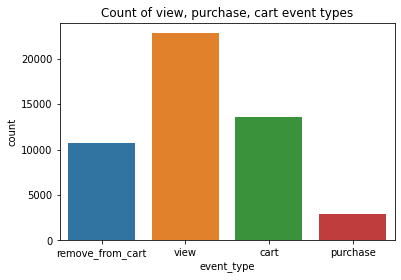

In [ ]:
#Count of event types
plt.title('Count of view, purchase, cart event types')
sns.countplot(x = 'event_type', data = df_Dec)

The data looks quite balanced.

# **EDA**

In [ ]:
sns.set(style="ticks")
numcols = ['user_id', 'product_id', 'category_id', 'price']
catcols = ['event_type','brand']
# Subset the columns
plot_df = df_Dec[numcols+ catcols]
# Few rows of data
plot_df.head()

,user_id,product_id,category_id,price,event_type,brand
0,576802932,5712790,1487580005268456287,6.27,remove_from_cart,f.o.x
1,412120092,5764655,1487580005411062629,29.05,view,cnd
2,494077766,4958,1487580009471148064,1.19,cart,runail
3,348405118,5848413,1487580007675986893,0.79,view,freedecor
4,576005683,5824148,1487580005511725929,5.56,view,Not Available


In [ ]:
!pip install dython
from dython import nominal

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


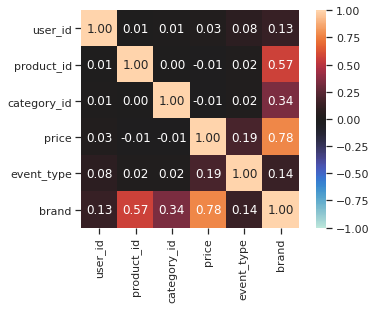

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8755fcff60>,
 'corr':               user_id  product_id  category_id     price  event_type     brand
 user_id      1.000000    0.006763     0.013303  0.029179    0.081753  0.131367
 product_id   0.006763    1.000000     0.000979 -0.009795    0.020341  0.568457
 category_id  0.013303    0.000979     1.000000 -0.013430    0.021808  0.340815
 price        0.029179   -0.009795    -0.013430  1.000000    0.190350  0.777730
 event_type   0.081753    0.020341     0.021808  0.190350    1.000000  0.139854
 brand        0.131367    0.568457     0.340815  0.777730    0.139854  1.000000}

In [ ]:
nominal.associations(plot_df, nominal_columns=catcols)

We can see that the correlation between price and brand is the highest and the correlation between brand and product id is the second highest. There is a considerable correlation between category id and brand as well.

In [ ]:
## We are calculating the total amount spent by each customer.
df1 = df_Dec.groupby(['user_id']).agg({'price': 'sum'}).reset_index()

In [ ]:
df1.head()

,user_id,price
0,31926511,91.45
1,48182054,277.08
2,59738436,33.02
3,69948697,6.19
4,72062431,178.44


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


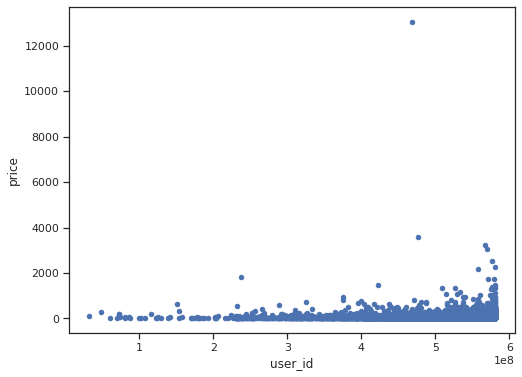

In [ ]:
df1.plot.scatter(x='user_id', y='price', figsize=(8,6))

In [ ]:
# df2 = df_Dec.groupby(['transaction_date']).count().reset_index()

In [ ]:
len(df_Dec['category_id'].unique())

381

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


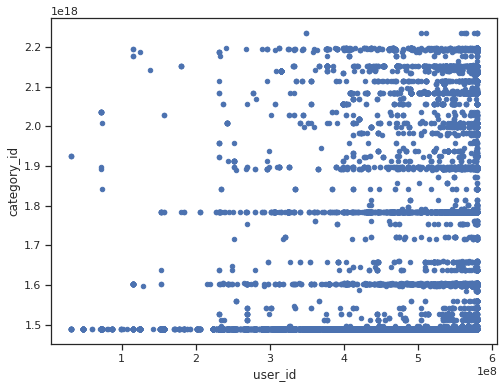

In [ ]:
df_Dec.plot.scatter(x='user_id', y='category_id', figsize=(8,6))

In [ ]:
# We are plotting only those users who 'purchased' items under the respective categories
df3 = df_Dec[df_Dec["event_type"] == "purchase"]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


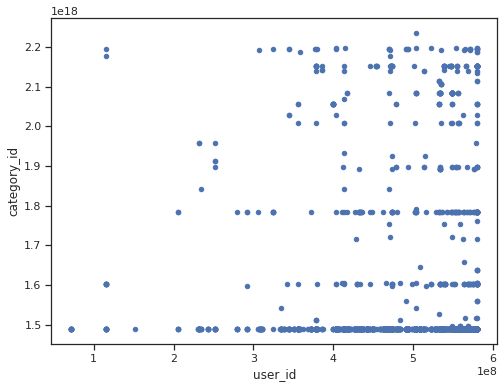

In [ ]:
df3.plot.scatter(x='user_id', y='category_id', figsize=(8,6))

# **K-Means using scikitLearn**
We are clustering the users based on their spending behaviour. As shown above, we've computed the total amount spent by each user and stored in a dataframe called df1. 
We then plot the total amount against their respective user_id.

In [ ]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df1)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1
count,7.292000e+03,7.292000e+03
mean,6.716149e-16,7.009691e-17
std,1.000069e+00,1.000069e+00
min,-6.470079e+00,-2.812090e-01
25%,-2.748715e-01,-2.560543e-01
50%,4.800756e-01,-2.092013e-01
75%,6.441085e-01,-2.596566e-02
max,6.462026e-01,6.237899e+01


Text(0, 0.5, 'Inertia')

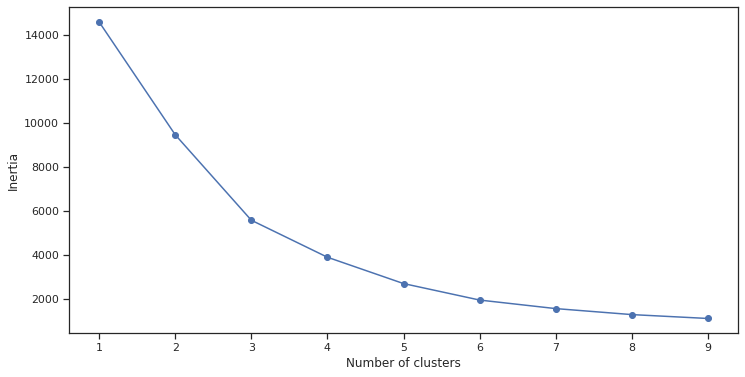

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
#Trying out 4 clusters decided from the above elbow plot
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_scaled)
y_kmeans = kmeans.predict(data_scaled)

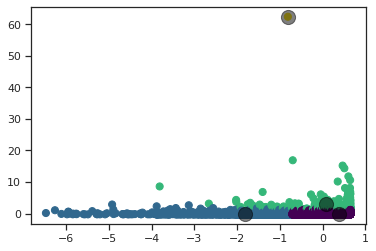

In [ ]:
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# **K-Means using tensor flow**

In [ ]:
## tf.session seems to be deprecated Tensorflow 2.0 onwards
tf.disable_v2_behavior()

def kmeans(feature1, feature2, num_clusters, steps=100):
    empty_list = []
    for i in range(len(feature1)):
        a = feature1[i]
        b = feature2[i]
        empty_list.append([a, b])
    new_array = np.array(empty_list)
    np.random.shuffle(new_array)    
    
    sess = tf.Session()
    k = num_clusters
    points = new_array
    data = tf.constant(points)
    
    # random initial centroids (points shuffled above)
    centroids = tf.Variable(data[:k, :])

    # add k dim to data and n dim to centroids to make matrices compatible
    # for array operations instead of loops
    data_expanded = tf.expand_dims(data, 0)
    centroids_expanded = tf.expand_dims(centroids, 1)

    # computes squared Euclidean distance between every point and every centroid
    # and get closest centroid for each point
    allocations = tf.argmin(tf.reduce_sum(tf.square(data_expanded - centroids_expanded), 2), 0)

    sess.run(tf.global_variables_initializer())
    c = 0 # index of centroid
    tf.equal(allocations, c)
    tf.gather(data, tf.where(tf.equal(allocations, c)))

    means = tf.concat(
        [tf.reduce_mean(
            tf.gather(data,
                      tf.where(tf.equal(allocations, c))), 0) for c in range(k)], 0)

    update_centroids = tf.assign(centroids, means)

    for step in range(steps):
        _, centroid_values, allocation_values = sess.run([update_centroids, centroids, allocations])
        
    num_clusters_df = pd.DataFrame({feature1.name: points[:,0], feature2.name: points[:,1], "cluster": allocation_values})
    sns.lmplot(feature1.name, feature2.name, data=num_clusters_df, fit_reg=False, size=6, hue="cluster")
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


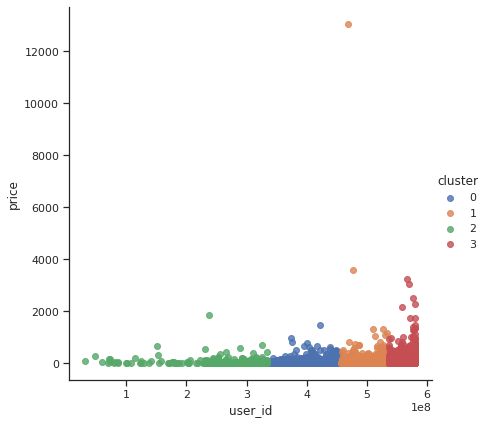

In [ ]:
kmeans(df1['user_id'], df1['price'], 4)